In [1]:
bond_dim=24
iLayer=30

path_dir='./data/' if bond_dim==24 else './data/X{0}/'.format(bond_dim)
path_dir_layers='./data/layers/' if bond_dim==24 else './data/X{0}/'.format(bond_dim)

filename1=path_dir+'hotrg_gilt_X{0}.pth'.format(bond_dim)
filename2=path_dir_layers+'hotrg_gilt_X{0}_lTRG_gilt_L{1}.pth'.format(bond_dim,iLayer)
filename_lattice=path_dir_layers+'hotrg_gilt_X{0}_lTRG_gilt_L{1}_lattice.pth'.format(bond_dim,iLayer)
filename_prefix_figures=path_dir_layers+'hotrg_gilt_X{0}_cyl_L{1}_'.format(bond_dim,iLayer)

# filename1='./data/hotrg_X24.pth'
# filename2='./data/hotrg_X24_lTRG_L20.pth'


In [2]:
from opt_einsum import contract
import torch
torch.set_default_tensor_type(torch.cuda.DoubleTensor)
device=torch.device('cuda:0')
torch.cuda.set_device(device)
import numpy as np
from transfer_matrix import get_scaling_dimensions_from_spectrum
from HOTRG import forward_observable_tensors, forward_layer
from TNModels import Ising2D
from tqdm.auto import tqdm
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.colors import hsv_to_rgb

In [3]:
print('loading coarse-grained tensors...')

loaded_dict=torch.load(filename1,map_location=device)
options,params,layers,Ts,logTotals=loaded_dict['options'],loaded_dict['params'],loaded_dict['layers'],loaded_dict['Ts'],loaded_dict['logTotals']
T0_op,checkerboard=Ising2D(params).get_observable('magnetization')

def forward_sigmas(positions):
    T_op=forward_observable_tensors(Ts[0],[T0_op]*len(positions),positions,layers[:20],checkerboard=checkerboard,cached_Ts=Ts,user_tqdm=False)[1]
    #T_op=T_op/T_op.norm()
    return T_op

print('done')


loading coarse-grained tensors...
done


In [4]:
T=Ts[iLayer]
M=contract('iIab,jJba->ijIJ',T,T).reshape(bond_dim**2,bond_dim**2)
s_cyl,u_cyl=torch.linalg.eig(M)# M=u*s@u.t().conj()
assert torch.isclose(M.cdouble()@u_cyl,u_cyl*s_cyl).all()
assert torch.isclose(u_cyl[:,:32].imag,torch.tensor(0.)).all()
assert torch.isclose(s_cyl.imag,torch.tensor(0.)).all()
u_cyl=u_cyl.real
s_cyl=s_cyl.real.abs()

scd_cyl=get_scaling_dimensions_from_spectrum(s_cyl,scaling=np.exp(2*np.pi/2))
scd_cyl=[f'{x:.3f}' for x in scd_cyl]
print(scd_cyl[:64])

['0.000', '0.126', '1.012', '1.140', '1.140', '2.038', '2.035', '2.043', '2.036', '2.161', '2.183', '2.190', '3.015', '3.055', '3.115', '3.114', '3.136', '3.131', '3.185', '3.214', '3.213', '3.242', '3.297', '3.329', '3.517', '3.508', '3.662', '3.698', '3.813', '3.913', '3.933', '3.994', '4.054', '3.997', '4.110', '4.129', '4.159', '4.184', '4.188', '4.234', '4.216', '4.316', '4.259', '4.309', '4.319', '4.347', '4.368', '4.368', '4.494', '4.530', '4.432', '4.410', '4.437', '4.458', '4.473', '4.514', '4.472', '4.469', '4.563', '4.600', '4.575', '4.583', '4.706', '4.638']


In [5]:
def apply_to_state_cyl(T1,T2,v):
    v_op=contract('iIab,jJba,IJ->ij',T1,T2,v.reshape(24,24)).flatten()
    v_op=v_op/v_op.norm()
    return v_op

def apply_to_vacuum_cyl(T1,T2):
    return apply_to_state_cyl(T1,T2,u_cyl[:,0])

data=[]
for x in tqdm(np.linspace(0,1,81)):
    intx=int(x*(2**11-1))
    T_op=forward_sigmas([(0,intx%2**10)])
    if intx>=2**10:
        v_op=apply_to_vacuum_cyl(T,T_op)
    else:
        v_op=apply_to_vacuum_cyl(T_op,T)
    overlap=torch.real(u_cyl.T.conj()@v_op)
    #overlap=overlap/overlap.norm()
    data.append({'x':x,'overlap':overlap.cpu().numpy()})

  0%|          | 0/81 [00:00<?, ?it/s]

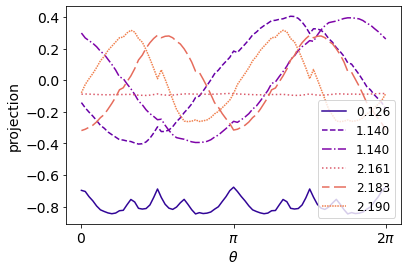

In [7]:
curve=pd.DataFrame(data)
overlaps=np.array(curve['overlap'].tolist())
plt.rcParams.update({'font.size': 14,'legend.fontsize':12})
plt.figure(figsize=(6,4))
cm=plt.get_cmap('plasma')
linestyles=['-','--','-.',':',(5, (10,3)),(0, (1, .7))]
iLinestyle=0
for i in range(16):
    overlap=overlaps[:,i]#/overlaps[:,1]
    if np.linalg.norm(overlap)>1e-5:
        plt.plot(curve['x']*2*np.pi,overlap,label=scd_cyl[i],color=cm(i/16),linestyle=linestyles[iLinestyle])
        iLinestyle=(iLinestyle+1)%len(linestyles)
plt.legend()
# plt.title(r'$\langle{O_i}|tr(T T)_{\sigma(r_0,\theta)}|0\rangle$')
plt.xlabel(r'$\theta$')
plt.xticks([0,np.pi,2*np.pi],[r'$0$',r'$\pi$',r'$2\pi$'])
plt.ylabel('projection')

plt.show()